# Training EmoNeXt

In [ ]:
# Define your variables
dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured' #64 epochs needs more trainign as it was stopped manually 
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured' #172epochs = 70% Test Accuracy | 10+ hrs Training
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
# dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured' #131epochs = 83.38% Test Accuracy | 6 hrs Training

batch_size = 32
learning_rate = 0.00001
epochs = 300
patience = 15
num_workers = 0 # Larger  than 0 will cause an error
model_size = ["tiny", "small", "base", "large", "xlarge"][1]
output_dir = "Models"
use_amp = True # Use Mixed Precision
use_22k = True # Use 22k model (larger model)
checkpoint = "Models/EmoNeXt_AffectNet_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt"

# Construct the %run command
run_command = f"EmoNeXt-master/train.py --dataset-name={dataset_name} --dataset-path={data_directory} --batch-size={batch_size} --patience={patience} --lr={learning_rate} --epochs={epochs} --num-workers={num_workers} --model-size={model_size} --output-dir={output_dir}"

# Add the --amp flag if use_amp is True
run_command += " --amp" if use_22k else ""

# Add the --in_22k flag if use_22k is True
run_command += " --in_22k" if use_22k else ""

run_command += f" --checkpoint {checkpoint}" if checkpoint != "" else ""

print(run_command)
# Execute the command
%run {run_command}

# Deriving Metrics on Testing Set

In [15]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

from ema_pytorch import EMA
import importlib  
models = importlib.import_module("EmoNeXt-master.models")

from torch.utils.data import ConcatDataset

def TestEmoNeXt(data_directory, model_path, base_model_size='small', base_model_in_22k=False, batch_size=15, dataset=['test']):

    # Define the mapping for the aligned labels
    # -ve keys are for the labels that are not present in the dataset
    # New Mapping - 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral, 7: Contempt
    if 'FER' in model_path.upper():
        print("FER Model")
        # Original Mapping: 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
        aligned_mapping = {0:0, 1:1, 2:2, 3:3, 4:6, 5:4, 6:5, -1:7}
    elif 'RAF' in model_path.upper():
        print("RAF Model")
        # Original Mapping: 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
        aligned_mapping = {0:0, 1:1, 2:2, 3:3, 4:6, 5:4, 6:5, -1:7}
    elif 'AFFECTNET' in model_path.upper():
        print("AffectNet Model")
        # Original Mapping: 0: Angry, 1: Contempt, 2: Disgust, 3: Fear, 4: Happy, 5: Neutral, 6: Sad, 7: Surprise
        aligned_mapping = {0:0, 1:7, 2:1, 3:2, 4:3, 5:6, 6:4, 7:5}
    elif 'JAFFE' in model_path.upper():
        print("JAFFE Model")
        # Original Mapping: 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise
        aligned_mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, -1:6, -2:7}
    elif 'CK+' in model_path.upper():
        print("CK+ Model")
        # Original Mapping: 0: Angry, 1: Contempt, 2: Disgust, 3: Fear, 4: Happy, 5: Neutral, 6: Sad, 7: Surprise
        aligned_mapping = {0:0, 1:7, 2:1, 3:2, 4:3, 5:6, 6:4, 7:5}

    # Update the label mapping for the dataset
    label_mapping = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6, 'Contempt': 7}

    ema_decay = 0.99 # Default unchnaged values
    ema_update_every = 16 # Default unchnaged values

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} device")

    # Transform the dataset
    transform = transforms.Compose(
        [
            transforms.Grayscale(),  # Convert image to grayscale if needed
            transforms.Resize(236),  # Resize the image
            transforms.TenCrop(224),  # Apply ten-cropping (10 different crops)
            transforms.Lambda(
                lambda crops: torch.stack(
                    [transforms.ToTensor()(crop) for crop in crops]
                )
            ),  # Convert each crop to tensor
            transforms.Lambda(
                lambda crops: torch.stack([crop.repeat(3, 1, 1) for crop in crops])
            ),
        ]
    )
    
    state_dict = torch.load(model_path, weights_only=True)

    final_fc_layer = [k for k in state_dict['model'].keys() if 'head' in k and 'weight' in k][-1]
    num_classes = state_dict['model'][final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    # Load the model architecture
    model = models.get_model(num_classes, base_model_size, base_model_in_22k) 

    model.load_state_dict(state_dict['model'], strict=False) 
    model.eval()

    ema_model = EMA(model, beta=ema_decay, update_every=ema_update_every).to(device)

    ema_model.load_state_dict(state_dict["ema"], strict=False)
    ema_model.eval()

    all_preds = []
    all_labels = []

    # Load the test dataset and aligning the labels
    # test_dataset = datasets.ImageFolder(f'{data_directory}/test', transform=transform, target_transform=lambda x: label_mapping[test_dataset.classes[x].capitalize()])  

    test_dataset = []
    for ds in dataset:
        dataset_part = datasets.ImageFolder(f'{data_directory}/{ds}', transform=transform, target_transform=lambda x: label_mapping[dataset_part.classes[x].capitalize()])  
        test_dataset.append(dataset_part)
    test_dataset = ConcatDataset(test_dataset)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = False, pin_memory = True)
    test_dataset.class_to_idx = label_mapping
    print(test_dataset.class_to_idx)

    cnt = 0
    # Iterate through test_loader to collect predictions and ground truth labels
    with torch.no_grad():
        for data in test_loader:
            print(cnt,'/',len(test_loader))
            cnt += 1
            inputs, labels = data[0].to(device), data[1].to(device)
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)   
            
            # Forward pass through the ema_model;
            _, logits = ema_model(inputs)
            
            # Reshape logits back to (batch_size, ncrops, num_classes) and average over crops
            outputs_avg = logits.view(bs, ncrops, -1).mean(1)
            predictions = torch.argmax(outputs_avg, dim=1)

            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate lists to form single arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    print("All Labels: ", all_labels)
    print("(B4 Mapping) All Predictions: ",all_preds)
    all_preds = [aligned_mapping[v] for v in all_preds]
    print("(After Mapping) All Predictions: ",all_preds)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Print the metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    # print("\nConfusion Matrix:\n", cm)

    # (Optional) Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

FER Model
Using cuda device
Number of classes: 7
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6, 'Contempt': 7}
0 / 2
1 / 2
All Labels:  [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5
 5 5 5 5 5 5 5]
(B4 Mapping) All Predictions:  [4 4 4 1 4 5 5 5 4 5 5 5 4 5 5 4 3 3 4 4 4 4 1 4 3 3 1 1 4 5 5 3 5 5 5 1 6
 2 5 6 6 5 4 6]
(After Mapping) All Predictions:  [6, 6, 6, 1, 6, 4, 4, 4, 6, 4, 4, 4, 6, 4, 4, 6, 3, 3, 6, 6, 6, 6, 1, 6, 3, 3, 1, 1, 6, 4, 4, 3, 4, 4, 4, 1, 5, 2, 4, 5, 5, 4, 6, 5]
Test Accuracy: 0.29545454545454547
Precision (Weighted): 0.4606060606060606
Precision (Macro): 0.30476190476190473
Precision (Micro): 0.29545454545454547
Recall (Weighted): 0.29545454545454547
Recall (Macro): 0.20833333333333331
Recall (Micro): 0.29545454545454547
F1 Score (Weighted): 0.32860575060063546
F1 Score (Macro): 0.2245767872366338
F1 Score (Micro): 0.29545454545454547

Classification Report:
               precision    recall  f

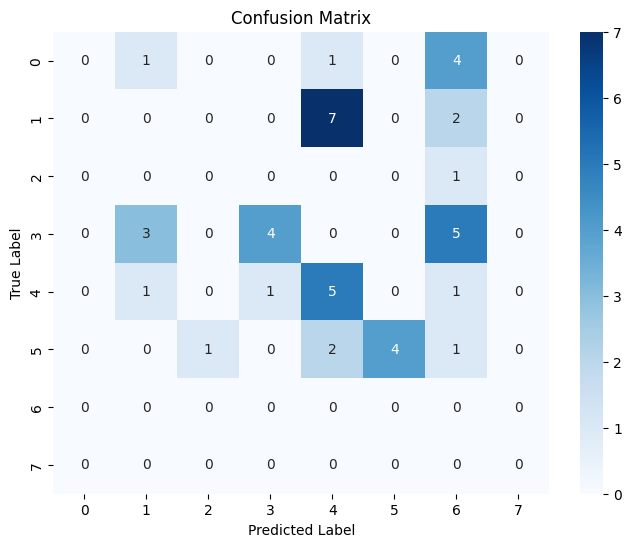

In [ ]:
data_directory = '../../Datasets/JAFFE_Structured'
# data_directory = '../../Datasets/FER_Structured'
# data_directory = '../../Datasets/RAF-DB_Structured'
# data_directory = '../../Datasets/CK+_Structured'
# data_directory = '../../Datasets/AffectNet_Structured'


model_path = 'Models/EmoNeXt_FER_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'
# model_path = 'Models/EmoNeXt_RAF-DB_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'
# model_path = 'Models/EmoNeXt_AffectNet_best_model_LR_1e-05_BS_32_P_15_E_300_MS_small_AMP_True_22K_True.pt'
base_model_size = 'small'
base_model_in_22k = True

TestEmoNeXt(data_directory, model_path, base_model_size, base_model_in_22k, batch_size=32)